## Interaction-Aware Motion Planning for Autonomous Vehicles with Multi-Modal Obstacle Uncertainty Predictions
### This case corresponds to Case 2 of the paper,where the ISA-MPC compared with Deterministic MPC, and the performance of ISA-MPC is examined by changing the value of the safety-awareness parameter
### The safety-awareness parameter is defined in Line 10 of Section 6

### 1. Import

In [1]:
import numpy as np
import math
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import casadi
import scipy.linalg as sl
from numpy.linalg import matrix_power
from scipy.io import loadmat

from Initialization_SV import Initialization_SV
from Initialization_EV import Initialization_EV
from IAIMM_KF import IAIMM_KF
from ISA_MPC import ISA_MPC
from CAM import CAM
from Driver_Model import Driver_Model

import pdb

%matplotlib auto

Using matplotlib backend: <object object at 0x7f6cc673a6d0>


### 2. Some Predefined Functions

In [2]:
class Priority_Sort( ): # Define the priority list in IAIMM-KF
    
    def __init__(self, infinity, L_Bound, N_Car, N, Ts, index_EV):
        self.N_Car = N_Car
        self.N = N
        self.Ts = Ts
        self.L_Bound = L_Bound
        self.infinity = infinity
        self.index_EV = index_EV
    
    def Define_lane_location(self, Lane_position):
        L_Bound = self.L_Bound
        
        if (L_Bound[0] <= Lane_position< L_Bound[1]):
            Lane_position = 1
        elif (L_Bound[1] <= Lane_position < L_Bound[2]):
            Lane_position = 2
        elif  (L_Bound[2] <= Lane_position):
            Lane_position = 3
        
        return Lane_position
    
    def Sort(self, k, Y_k):
        N_Car = self.N_Car
        N = self.N
        Ts = self.Ts
        infinity = self.infinity
        index_EV = self.index_EV
        
        list_priority = np.zeros((2, N_Car))
        list_priority[0, :] = range(0, N_Car)
        x_initial_1 = list([infinity]*N_Car)    
        x_terminal_1 = list([infinity]*N_Car) 
        x_initial_2 = list([infinity]*N_Car)     
        x_terminal_2 = list([infinity]*N_Car) 
        x_initial_3 = list([infinity]*N_Car)    
        x_terminal_3 = list([infinity]*N_Car) 
        
        for i in range(N_Car):
            if i != index_EV:
                y_pos = Y_k[i][2]
                x_pos = Y_k[i][0]
                velocity = Y_k[i][1]
            else:
                y_pos = Y_k[i][0][2]
                x_pos = Y_k[i][0][0]
                velocity = Y_k[i][0][1]
            Lane_location = self.Define_lane_location(y_pos)
            if Lane_location == 1: 
                x_initial_1[i] = x_pos
                x_terminal_1[i] = x_pos + velocity*N*Ts
            elif Lane_location == 2: 
                x_initial_2[i] = x_pos
                x_terminal_2[i] = x_pos + velocity*N*Ts
            elif Lane_location == 3: 
                x_initial_3[i] = x_pos
                x_terminal_3[i] = x_pos + velocity*N*Ts

        for i in range(N_Car):
            x_initial_index_min_1 = np.argmin(x_initial_1) 
            x_terminal_min_1 = x_terminal_1[x_initial_index_min_1] 

            x_initial_index_min_2 = np.argmin(x_initial_2) 
            x_terminal_min_2 = x_terminal_2[x_initial_index_min_2] 
            
            x_initial_index_min_3 = np.argmin(x_initial_3) 
            x_terminal_min_3 = x_terminal_3[x_initial_index_min_3] 
            
            index_terminal = np.argmin([x_terminal_min_1, x_terminal_min_2, x_terminal_min_3])
            
            if index_terminal == 0:
                index = x_initial_index_min_1
                x_initial_1[index] = infinity
                x_terminal_1[index] = infinity
            elif index_terminal == 1:
                index = x_initial_index_min_2
                x_initial_2[index] = infinity
                x_terminal_2[index] = infinity
            elif index_terminal == 2:
                index = x_initial_index_min_3
                x_initial_3[index] = infinity
                x_terminal_3[index] = infinity
            
            list_priority[1, index] = i
        
        list_use = list_priority[1, :] 
        return list_use

def Cal_Vertex(x, y, theta, l, w): # Compute the shape of the car, for visualization
    box = np.array([[x-l/2, y+w/2], [x+l/2, y+w/2], [x+l/2, y-w/2], [x-l/2, y-w/2]])
    box_matrix = box - np.tile([x, y], (box.shape[0], 1))
    theta = -theta
    rota_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    new = np.dot(box_matrix, rota_matrix) + np.tile([x, y], (box.shape[0], 1))
    
    x = [new[0, 0], new[1, 0], new[2, 0], new[3, 0], new[0, 0]]
    y = [new[0, 1], new[1, 1], new[2, 1], new[3, 1], new[0, 1]]
    
    return x, y

def OCC_SV_Vertex(OCC_Obstacle): # Visualize the occupancy (occ.) of the SV
    x_bar = OCC_Obstacle[0]
    y_bar = OCC_Obstacle[1]
    dx = OCC_Obstacle[2]
    dy = OCC_Obstacle[3]
    
    xe1 = x_bar - dx
    xe2 = x_bar + dx
    xe3 = x_bar + dx 
    xe4 = x_bar - dx
    
    ye1 = y_bar - dy 
    ye2 = y_bar - dy
    ye3 = y_bar + dy
    ye4 = y_bar + dy
    
    X = [xe1, xe2, xe3, xe4, xe1]    
    Y = [ye1, ye2, ye3, ye4, ye1]
    return X, Y 

### 3. Load Driving Model Parameters

In [3]:
# The file 'Model_Parameters.mat' contains the parameters of IAIMM-KF, which is identified offline
Model_Parameters = loadmat(r'Model_Parameters.mat')
Model_Parameters = Model_Parameters['Model_Parameters']
Model_Parameters = Model_Parameters[0, 0]

m0 =   [Model_Parameters['m0']['Lon'][0][0][0], Model_Parameters['m0']['Lat'][0][0][0]] 
m1 =   [Model_Parameters['m1']['Lon'][0][0][0], Model_Parameters['m1']['Lat'][0][0][0]] 
m2 =   [Model_Parameters['m2']['Lon'][0][0][0], Model_Parameters['m2']['Lat'][0][0][0]] 
m3 =   [Model_Parameters['m3']['Lon'][0][0][0], Model_Parameters['m3']['Lat'][0][0][0]] 
m4 =   [Model_Parameters['m4']['Lon'][0][0][0], Model_Parameters['m4']['Lat'][0][0][0]] 
m5 =   [Model_Parameters['m5']['Lon'][0][0][0], Model_Parameters['m5']['Lat'][0][0][0]] 
m6 =   [Model_Parameters['m6']['Lon'][0][0][0], Model_Parameters['m6']['Lat'][0][0][0]] 
std_m0 = [Model_Parameters['m0']['K_set_lon'][0][0][0], Model_Parameters['m0']['std_y'][0][0][0]]
std_m1 = [Model_Parameters['m1']['K_set_lon'][0][0][0], Model_Parameters['m1']['K_set_lat'][0][0][0]]
std_m2 = [Model_Parameters['m2']['K_set_lon'][0][0][0], Model_Parameters['m2']['K_set_lat'][0][0][0]]
std_m3 = [Model_Parameters['m3']['K_set_lon'][0][0][0], Model_Parameters['m3']['std_y'][0][0][0]]
std_m4 = [Model_Parameters['m4']['K_set_lon'][0][0][0], Model_Parameters['m4']['K_set_lat'][0][0][0]]
std_m5 = [Model_Parameters['m5']['K_set_lon'][0][0][0], Model_Parameters['m5']['K_set_lat'][0][0][0]]
std_m6 = [Model_Parameters['m6']['K_set_lon'][0][0][0], Model_Parameters['m6']['std_y'][0][0][0]]

Models = [m0, m1, m2, m3, m4, m5, m6] # submodels (controller gains of nominal maneuvers)
std_parameters = [std_m0, std_m1, std_m2, std_m3, std_m4, std_m5, std_m6] # parameters of standard deviation

### 4. Define Basic parameters

In [4]:
# basic parameters
Ts = 0.32         # time interval
N = 25            # prediction horizon
N_Lane = 3        # number of lanes
N_M = 7           # number of sub-models of SVs
N_M_EV = 3        # number of sub-models of EV
N_Car = 6         # number of cars involving EV and SVs
index_EV  = 5     # index of EV
L_Width = [3.75, 3.75, 3.75]             # width of each lane
L_Bound = [0, 3.75, 3.75*2, 3.75*3]      # land boundaries
L_Center = [3.75/2, 3.75 + 3.75/2, 3.75*2 + 3.75/2] # lane center positions
l_veh = 4.3        # vehicle length 
w_veh = 1.8        # vehicle width
Th_long = 2        # long time headway
Th_short = 1.5     # short time headway
DSV = 6            # dimension of SVs
DEV = 8            # dimension of EV
Dev =  np.array([0.015, 1.8])                 #  threshold of phi and y
K_Lon_EV = np.array([0.1029, 0.3423])         # long. controller gains of EV
K_Lat_EV = np.array([0.0984, 0.4656, 0.5417]) # lateral controller gains of EV
SpeedLim = np.array([65/3.6, 90/3.6, 90/3.6]) # speed limit of each lane
Weight =  np.array([0.1, 0.3, 0.1, 0.5])      # wight for ax ay vx y
H = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]) # selection matrix for observations from the state
l_f = 1.446       # vehicle parameter
l_r =1.477        # vehicle parameter
acc = -1.2        # acceleration of SV4
infinity = 100000 # represents infinity
Q = np.diag([1, 0.5, 0.25, 0.1, 0.1, 0])     # Q matrix in Kalman filter -- Tunable
R = np.diag([1, 1, 1])*1e-5                  # R matrix in Kalman filter -- Tunable
K_sampling = 30                              # the sampling size for estimating the variance of  x and y

opts_SV = { # parameters of SV
    'Ts': Ts,     
    'N': N,   
    'N_Lane': N_Lane, 
    'N_M': N_M,         
    'N_Car': N_Car,     
    'L_Width': L_Width,    
    'w_veh': w_veh, 
    'l_veh': l_veh,  
    'L_Bound': L_Bound, 
    'L_Center': L_Center, 
    'DSV': DSV,  
    'infinity': infinity,
    'SpeedLim': SpeedLim, 
    'Q': Q, 
    'R': R, 
    'Weight': Weight,
    'H': H, 
    'Models': Models,
    'std_parameters': std_parameters,
    'K_sampling': K_sampling,
}
opts_EV = { # parameters of EV
    'index_EV': index_EV,
    'Ts': Ts,      
    'N': N,     
    'N_Lane': N_Lane, 
    'N_M': N_M, 
    'N_M_EV': N_M_EV, 
    'N_Car': N_Car,   
    'L_Center': L_Center, 
    'L_Bound': L_Bound, 
    'w_veh': w_veh, 
    'l_veh': l_veh,  
    'zeta_l': 0.5,
    'zeta_w': 0.5,
    'zeta_EV': 0.5,
    'Th_MPC': Th_short, 
    'Th_QP': Th_long, 
    'DSV': DSV,       
    'DEV': DEV,    
    'Dev': Dev, 
    'K_Lon_EV': K_Lon_EV,
    'K_Lat_EV': K_Lat_EV,
    'l_f': l_f,  
    'l_r': l_r,  
    'SpeedLim': SpeedLim, 
    'Weight': Weight,
    'H': H, 
    'infinity': infinity,
    'Models': Models,
    'Q_Initial': [0.5, 0.1, 0.5, 0.1, 0.05, 1, 0.055], # weight for MPC of initialization
    'Q1': 0.5,      # longitudianl snap
    'Q2': 0.1,      # front tire angle acceleration
    'Q3': 0.5,      # longitudinal acceleration
    'Q4': 0.1,      # front tire wheel angle 
    'Q5': 0.05,     #  terminal lateral error
    'Q6': 1,        #  terminal longitudinal position error
    'Q7': 0.055,    # slack variable
}
opts_CA = { # parameters of the constant acceleration vehicle -- SV3
    'Ts': Ts,      
    'DSV': DSV,      
    'N': N,     
    'N_M': N_M,     
    'L_Center': L_Center,     
    'Models': Models,
    'acc': acc, 
    'H': H, 
}
opts_Driver = {# The human-driven vehicle -- SV4
    'Ts': Ts,      
    'DSV': DSV,      
    'N': N,     
    'L_Center': L_Center,     
    'H': H, 
    'SpeedLim': SpeedLim, 
    'L_Bound': L_Bound, 
}

# Lateral position of lanes
L_No1 = L_Center[0]
L_No2 = L_Center[1]
L_No3 = L_Center[2]

### 5. Initialization

In [5]:
# global initial state
index_Bro = 3     # index of the breaking SV -- SV3
ispeed_EV = 95    # initial speed of EV
ixposition_EV = 0 # initial position of EV
x_0_0 = np.array([250, 60/3.6, 0, L_No1, 0, 0])  # initial state of SV0
x_0_1 = np.array([200, 60/3.6, 0, L_No1, 0, 0])  # initial state of SV1
x_0_2 = np.array([100, 108/3.6, 0, L_No2, 0, 0]) # initial state of SV2
x_0_3 = np.array([80, 95/3.6, 0, L_No3, 0, 0])   # initial state of SV3
x_0_4 = np.array([25, 95/3.6, 0, L_No3, 0, 0])   # initial state of SV4
x_0_5 = np.array([ixposition_EV, ispeed_EV/3.6, 0, L_No1, 0, 0])             # initial state of EV
x_0_EV_glo = np.array([ixposition_EV, ispeed_EV/3.6, 0, L_No1, 0, 0])        # initial state of EV in global frame
x_0_EV_loc = np.array([ixposition_EV, L_No1, 0, ispeed_EV/3.6, 0, 0, 0, 0])  # initial state of EV in vehicle frame

X_Hat = list( )     # the estimation of state of each mode
MU = list( )        # the probability
P = list( )         # the covariance matrix in IMM-KF
Y = list( )         # the measurement
M = list( )         # the activated model -- models which are effective
X_Pre = list( )     # the prediction
X_Po_All = list( )                 # the all possible predictions
Ref_Speed = list( )                # reference speed of cars
Ref_Lane = list( )                 # reference lane of cars
Ref_Speed_All = list( )            # reference speed of all modes of each car
X_State = list( )                  # the state of each car at every step
X_State_EV_LOC = list( )           # the state of EV in the local frame at every step
X_State_EV_GLO = list( )           # the  state of EV in the global frame at every step
Trajectory_EV_LOC = list( )        # the planned trajectory of EV at every step
OCC_SV = list( )                   # the convex hull of nearest car  on each lane at every step
X_Var = list( )                    # the x trajectory variance of all models of all SVs
Y_Var  = list( )                   # the y trajectory variance of all models of all SVs
Prio_List = list( )                # the dynamic priority list
Control_EV = list( )               # collect the control of EV in horizon
True_State_LC = list( )            # the true state of the LC car controlled by human driver

X_State_0 = [x_0_0, x_0_1, x_0_2, x_0_3, x_0_4, [x_0_5, x_0_5, x_0_5]] # collect the initial states of all vehicles
X_State.append(X_State_0) 

# initialization of EV and SV
Initial_SV =Initialization_SV(Params = opts_SV)
Initial_EV = Initialization_EV(Params = opts_EV, state_0_glo = x_0_EV_glo, state_0_loc = x_0_EV_loc)
MU_0, M_0,  Y_0, Y_1, X_Hat_0, P_0, X_Pre_0, X_Po_All_0, X_Var_0, Y_Var_0, REF_Speed_0, REF_Lane_0, REF_Speed_All_0 = Initial_SV.Initialize_MU_M_P(X_State, index_EV)
mu_0, m_0,  x_hat_0, x_pre_0, Traj_0, U_0, state_1_loc, state_1_glo, y_0, y_1, OCC_SV_0, RefSpeed_EV_0, REF_EV_0  = Initial_EV.Initialization_MPC(x_0_EV_glo, x_0_EV_loc, X_State_0, index_EV, X_Pre_0)

#  initial storage
MU_0[index_EV] = [mu_0, mu_0, mu_0]
M_0[index_EV] = [m_0, m_0, m_0]
Y_0[index_EV] = [y_0, y_0, y_0]
Y_1[index_EV] = [y_1, y_1, y_1]
X_Hat_0[index_EV] = [x_hat_0, x_hat_0, x_hat_0]
X_Pre_0[index_EV] = [x_pre_0, x_pre_0, x_pre_0]
X_Po_All_0[index_EV] = [None, None, None]
REF_Speed_0[index_EV] = [RefSpeed_EV_0, RefSpeed_EV_0, RefSpeed_EV_0]
REF_Lane_0[index_EV] = [L_Center[0], L_Center[0], L_Center[0]]
REF_Speed_All_0[index_EV] = [REF_EV_0, REF_EV_0, REF_EV_0]

MU.append(MU_0)
M.append(M_0)
Y.append(Y_0)
Y.append(Y_1)
X_Hat.append(X_Hat_0)
X_Pre.append(X_Pre_0)
X_Po_All.append(X_Po_All_0)
X_Var.append(X_Var_0)
Y_Var.append(Y_Var_0)
P.append(P_0)
Ref_Speed.append(REF_Speed_0)
Ref_Lane.append(REF_Lane_0)
Ref_Speed_All.append(REF_Speed_All_0)
True_State_LC.append(x_0_4)

X_State_EV_LOC.append([x_0_EV_loc, x_0_EV_loc, x_0_EV_loc])     # step 0
X_State_EV_GLO.append([x_0_EV_glo, x_0_EV_glo, x_0_EV_glo])     # step 0
X_State_EV_LOC.append([state_1_loc, state_1_loc, state_1_loc])  # step 1
X_State_EV_GLO.append([state_1_glo, state_1_glo, state_1_glo])  # step 1
OCC_SV.append([OCC_SV_0, OCC_SV_0, OCC_SV_0])
Trajectory_EV_LOC.append([Traj_0, Traj_0, Traj_0])
Control_EV.append([U_0, U_0, U_0])

# initialize priority
Sorting = Priority_Sort(infinity = infinity, L_Bound = L_Bound, N_Car = N_Car, N = N, Ts = Ts, index_EV = index_EV)
Prio_List.append(Sorting.Sort(0, Y[0]))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



### 6. Simulation

In [6]:
K_N = 100    # the number of all simulation steps
k_b = 6      # the time point when the SV3 is starting breaking
k_c = 11     # the time point when the car SV4 changes lane, controlled by human
IMM_KF =  IAIMM_KF(Params = opts_SV)
MPC    =  ISA_MPC(Params = opts_EV)  
CA     = CAM(Params = opts_CA)
Driver = Driver_Model(Params = opts_Driver)
K_set_lon_driver = std_parameters[5][0]
K_set_lat_driver  = std_parameters[5][1]
Epsilon = [0.1, 0.4, 1] # Important, safety-awareness parameter \epsilon_k, \epsilon_k = 1 is Deterministic MPC

for k in range(1, K_N):
    list_k = Sorting.Sort(k, Y[k])
    MU_k            = [None]*N_Car 
    M_k             = [None]*N_Car 
    X_Hat_k         = [None]*N_Car 
    X_State_k       = [None]*N_Car 
    P_k             = [None]*N_Car     
    X_Pre_k         = [None]*N_Car 
    Y_k_plus_1      = [None]*N_Car 
    Obst_k          = [None]*N_Car 
    X_Po_All_k      = [None]*N_Car 
    X_Var_k         = [None]*N_Car 
    Y_Var_k         = [None]*N_Car 
    Ref_Speed_k     = [None]*N_Car 
    Ref_Lane_k      = [None]*N_Car 
    Ref_Speed_All_k = [None]*N_Car
    print('The step is', k)
    for i in range(N_Car):
            car_index = np.argwhere(list_k == np.max(list_k)) # fetch the car with highest priority
            car_index = car_index[0][0]                       # index of highest-prioritized car
            list_k[car_index] = -1                            # when the car is fecthed out, fill the position by -1
            if car_index != index_EV:
                if (car_index == index_Bro ) and (k >= k_b):  #  initiate SV3 which statrs to break
                    Ref_speed, Ref_lane, REF_Speed_All, mu_k, m_k, x_hat_k, p_k, x_state_k, x_pre_k, y_k_plus_1, x_po_all_k, x_var_k, y_var_k = CA.Final_Return(k, X_Hat, Y, car_index)
                elif (car_index == 4) and (k >= k_c):                              # initiate SV4 which is controlled by human
                    random_index = np.random.randint(0, len(K_set_lon_driver) - 1) # randomly generate the controller gains SV4
                    K_Lon_Driver   = K_set_lon_driver[random_index][0]
                    K_Lat_Driver    = K_set_lat_driver[random_index][0]
                    y_k_plus_1, x_state_k_plus_1 = Driver.Final_Return(k, True_State_LC, K_Lon_Driver, K_Lat_Driver)
                    Ref_speed, Ref_lane, mu_k, m_k, x_hat_k, p_k, x_state_k, x_pre_k, REF_Speed_All, x_po_all_k, x_var_k, y_var_k = IMM_KF.Final_Return_Predictor(k, MU, X_Hat, P, Y, Obst_k, car_index)
                    True_State_LC.append(x_state_k_plus_1) 
                else:
                    Ref_speed, Ref_lane, mu_k, m_k, x_hat_k, p_k, x_state_k, x_pre_k, y_k_plus_1, REF_Speed_All, x_po_all_k, x_var_k, y_var_k = IMM_KF.Final_Return_Simulator(k, MU, X_Hat, P, Y, Obst_k, car_index)
                    if car_index == 4:
                        True_State_LC.append(x_state_k)
                        if k == (k_c - 1):
                            True_State_LC.append(x_pre_k[:, 1])
                X_State_k[car_index] = x_state_k
                P_k[car_index] = p_k
                X_Po_All_k[car_index] = x_po_all_k    
                Obst_k[car_index]  = x_pre_k
                X_Var_k[car_index] = x_var_k
                Y_Var_k[car_index] = y_var_k
            else:
                Ref_speed          = list([None]*3)
                Ref_lane           = list([None]*3)
                mu_k               = list([None]*3)
                m_k                = list([None]*3)
                x_hat_k            = list([None]*3)
                x_pre_k            = list([None]*3)
                Traj_k             = list([None]*3)
                u_k                = list([None]*3)
                state_k_plus_1_loc = list([None]*3)
                state_k_plus_1_glo = list([None]*3)
                y_k_plus_1         = list([None]*3)
                OCC_SV_k           = list([None]*3)
                REF_Speed_All      = list([None]*3)
                for j in range(len(Epsilon)):
                    epsilon = Epsilon[j]
                    Ref_speed[j], Ref_lane[j], mu_k[j], m_k[j], x_hat_k[j], x_pre_k[j], Traj_k[j], u_k[j], state_k_plus_1_loc[j], state_k_plus_1_glo[j], y_k_plus_1[j],  OCC_SV_k[j], REF_Speed_All[j] = MPC.Final_Return(k, X_State_EV_LOC[k][j], X_State_EV_GLO[k][j], Obst_k, Y[k][car_index][j], X_Po_All_k, MU_k, X_Var_k, Y_Var_k, epsilon)
                X_State_k[car_index] = X_State_EV_GLO[k]
                X_State_EV_LOC.append(state_k_plus_1_loc)
                X_State_EV_GLO.append(state_k_plus_1_glo)
                Control_EV.append(u_k)
                OCC_SV.append(OCC_SV_k)
                P_k[car_index] = None
                X_Po_All_k[car_index] = x_pre_k    
                Obst_k[car_index] = x_pre_k
                X_Var_k[car_index] = None
                Y_Var_k[car_index] = None
                
            MU_k[car_index] = mu_k
            M_k[car_index] = m_k
            X_Hat_k[car_index] = x_hat_k
            X_Pre_k[car_index] = x_pre_k
            Y_k_plus_1[car_index] = y_k_plus_1
            Ref_Speed_k[car_index] = Ref_speed
            Ref_Speed_All_k[car_index] = REF_Speed_All
            Ref_Lane_k[car_index] = Ref_lane
            
    MU.append(MU_k)
    M.append(M_k)
    X_Hat.append(X_Hat_k)
    X_State.append(X_State_k)
    X_Pre.append(X_Pre_k)
    P.append(P_k)
    Y.append(Y_k_plus_1)
    X_Po_All.append(X_Po_All_k)
    Ref_Speed.append(Ref_Speed_k)
    Ref_Lane.append(Ref_Lane_k)
    Ref_Speed_All.append(Ref_Speed_All_k)
    X_Var.append(X_Var_k)
    Y_Var.append(Y_Var_k)
    Prio_List.append(Sorting.Sort(k, Y[k]))

The step is 1
The step is 2
The step is 3
The step is 4
The step is 5
The step is 6
The step is 7
The step is 8
The step is 9
The step is 10
The step is 11
The step is 12
The step is 13
The step is 14
The step is 15
The step is 16
The step is 17
The step is 18
The step is 19
The step is 20
The step is 21
The step is 22
The step is 23
The step is 24
The step is 25
The step is 26
The step is 27
The step is 28
The step is 29
The step is 30
The step is 31
The step is 32
The step is 33
The step is 34
The step is 35
The step is 36
The step is 37
The step is 38
The step is 39
The step is 40
The step is 41
The step is 42
The step is 43
The step is 44
The step is 45
The step is 46
The step is 47
The step is 48
The step is 49
The step is 50
The step is 51
The step is 52
The step is 53
The step is 54
The step is 55
The step is 56
The step is 57
The step is 58
The step is 59
The step is 60
The step is 61
The step is 62
The step is 63
The step is 64
The step is 65
The step is 66
The step is 67
The 

### 7. Collect the Data for Analysis

In [7]:
t = np.arange(0, Ts*K_N, Ts, dtype=float)     # total simulation time
State_EV_LOC_Small_Eps = np.zeros([DEV, K_N]) # collect the state of EV in local system
State_EV_LOC_Large_Eps = np.zeros([DEV, K_N]) # collect the state of EV in local system
State_EV_LOC_Determini = np.zeros([DEV, K_N]) # collect the state of EV in local system
State_SV_0 = np.zeros([DSV, K_N])             # collect the state of SV no.0
State_SV_1 = np.zeros([DSV, K_N])             #  collect the state of SV no.1
State_SV_2 = np.zeros([DSV, K_N])             #  collect the state of SV no.2
State_SV_3 = np.zeros([DSV, K_N])             #  collect the state of SV no.3
State_SV_4 = np.zeros([DSV, K_N])             #  collect the state of SV no.4

Ref_Speed_EV_Small_Eps = np.array([None]*K_N) # collect the reference speed of EV
Ref_Lane_EV_Small_Eps = np.array([None]*K_N)  # collect reference lane of EV
Snap_Small_Eps = np.array([None]*K_N)         # collect longitudinal snap
Alpha_Small_Eps = np.array([None]*K_N)        # collect angular acceleration

Ref_Speed_EV_Large_Eps = np.array([None]*K_N) # collect the reference speed of EV
Ref_Lane_EV_Large_Eps = np.array([None]*K_N)  # collect reference lane of EV
Snap_Large_Eps = np.array([None]*K_N)         # collect longitudinal snap
Alpha_Large_Eps = np.array([None]*K_N)        # collect angular acceleration

Ref_Speed_EV_Determini  = np.array([None]*K_N) # collect the reference speed of EV
Ref_Lane_EV_Determini  = np.array([None]*K_N)  # collect reference lane of EV
Snap_Determini  = np.array([None]*K_N)         # collect longitudinal snap
Alpha_Determini  = np.array([None]*K_N)        # collect angular acceleration

for i in range(K_N):
    State_EV_LOC_Small_Eps[:, i] = X_State_EV_LOC[i][0]
    State_EV_LOC_Large_Eps[:, i] = X_State_EV_LOC[i][1]
    State_EV_LOC_Determini[:, i] = X_State_EV_LOC[i][2]
        
    State_SV_0[:, i] = X_State[i][0]
    State_SV_1[:, i] = X_State[i][1]
    State_SV_2[:, i] = X_State[i][2]
    State_SV_3[:, i] = X_State[i][3]
    State_SV_4[:, i] = X_State[i][4]
    
    Snap_Small_Eps[i] = Control_EV[i][0][1, 0]
    Snap_Large_Eps[i] = Control_EV[i][1][1, 0]
    Snap_Determini[i] = Control_EV[i][2][1, 0]
    Alpha_Small_Eps[i] = Control_EV[i][0][2, 0]
    Alpha_Large_Eps[i] = Control_EV[i][1][2, 0]
    Alpha_Determini[i] = Control_EV[i][2][2, 0]
    
    Ref_Speed_EV_Small_Eps[i] = Ref_Speed[i][index_EV][0]
    Ref_Speed_EV_Large_Eps[i] = Ref_Speed[i][index_EV][1]
    Ref_Speed_EV_Determini[i] = Ref_Speed[i][index_EV][2]
    Ref_Lane_EV_Small_Eps[i] = Ref_Lane[i][index_EV][0]
    Ref_Lane_EV_Large_Eps[i] = Ref_Lane[i][index_EV][1]
    Ref_Lane_EV_Determini[i] = Ref_Lane[i][index_EV][2]
    
    for j in range(N_Car):
        if j == index_EV:
            for h in range(3):
                for k in range(N_M_EV):
                    if Ref_Speed_All[i][j][h][k] == None:
                        Ref_Speed_All[i][j][h][k] = 0
        else:
            for k in range(N_M):
                if Ref_Speed_All[i][j][k] == None:
                    Ref_Speed_All[i][j][k] = 0

### 8. Animation

##### 8.1 Results for epsilon = 0.1

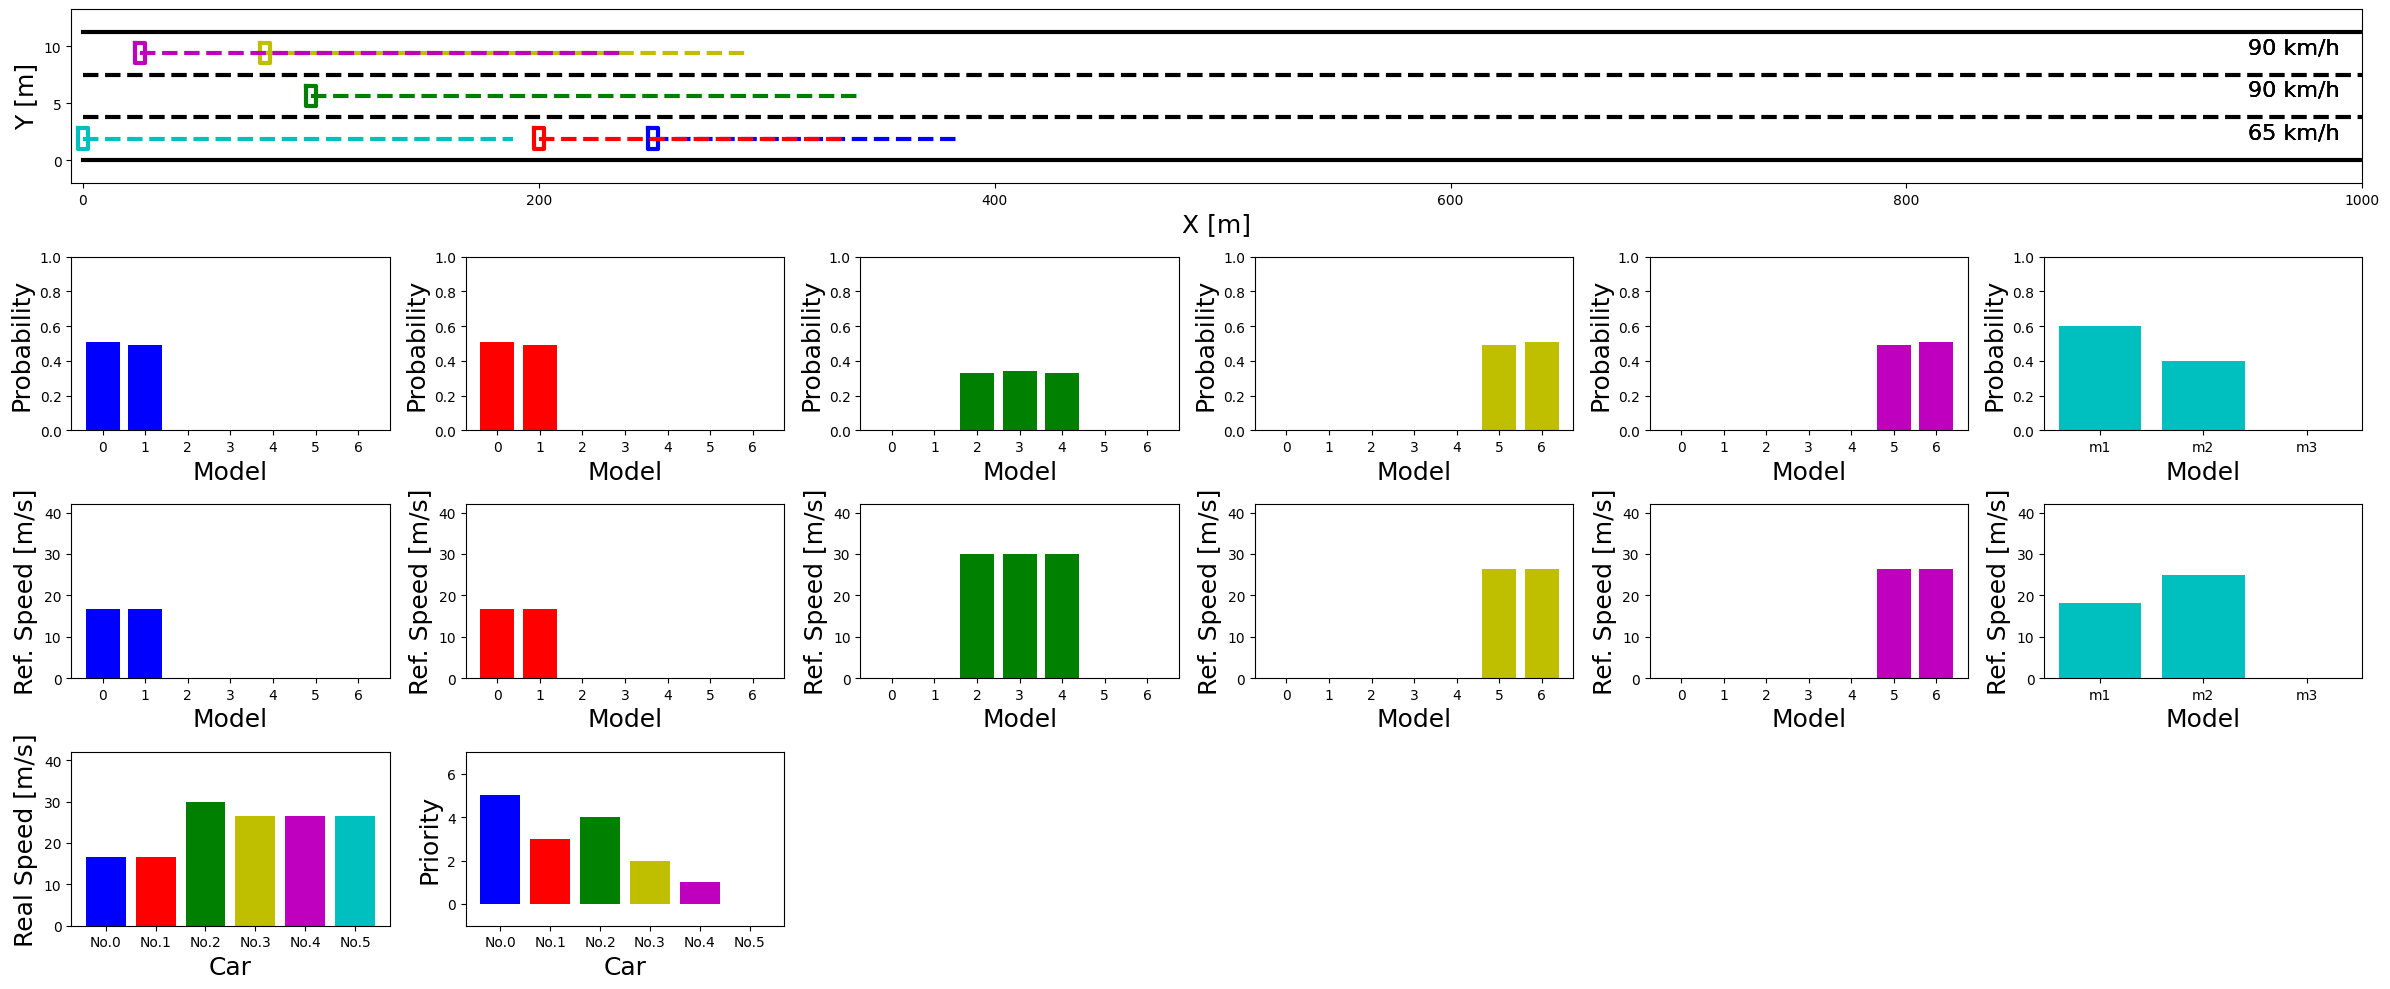

In [8]:
%matplotlib inline
control_index = 0
color_car = ['b', 'r', 'g', 'y', 'm', 'c'] 
color_tra = ['b--', 'r--', 'g--', 'y--', 'm--', 'c--']
x_max = 1000 
fig = plt.figure(figsize=(24, 10), tight_layout = True)
ax = fig.add_subplot(4,1,1,xlim=(-5,  x_max), ylim=(-2, L_Bound[-1] - L_Bound[0]+2))
ax_pro_0 = fig.add_subplot(4, 6, 7,   ylim=(0, 1))
ax_pro_1 = fig.add_subplot(4, 6, 8,   ylim=(0, 1))
ax_pro_2 = fig.add_subplot(4, 6, 9,   ylim=(0, 1))
ax_pro_3 = fig.add_subplot(4, 6, 10, ylim=(0, 1))
ax_pro_4 = fig.add_subplot(4, 6, 11, ylim=(0, 1))
ax_pro_5 = fig.add_subplot(4, 6, 12, ylim=(0, 1))
ax_ref_0 =  fig.add_subplot(4, 6, 13, ylim = (0, 42))
ax_ref_1 =  fig.add_subplot(4, 6, 14, ylim = (0, 42))
ax_ref_2 =  fig.add_subplot(4, 6, 15, ylim = (0, 42))
ax_ref_3 =  fig.add_subplot(4, 6, 16, ylim = (0, 42))
ax_ref_4 =  fig.add_subplot(4, 6, 17, ylim = (0, 42))
ax_ref_5 =  fig.add_subplot(4, 6, 18, ylim = (0, 42))
ax_real_speed = fig.add_subplot(4, 6, 19, ylim = (0, 42))
ax_prio_list = fig.add_subplot(4, 6, 20, ylim = (-1, 7))
ax.set_xlabel('X [m]', fontsize = 18)
ax.set_ylabel('Y [m]', fontsize = 18)
ax_pro_0.set_xlabel('Model', fontsize = 18)
ax_pro_0.set_ylabel('Probability', fontsize = 18)
ax_pro_1.set_xlabel('Model', fontsize = 18)
ax_pro_1.set_ylabel('Probability', fontsize = 18)
ax_pro_2.set_xlabel('Model', fontsize = 18)
ax_pro_2.set_ylabel('Probability', fontsize = 18)
ax_pro_3.set_xlabel('Model', fontsize = 18)
ax_pro_3.set_ylabel('Probability', fontsize = 18)
ax_pro_4.set_xlabel('Model', fontsize = 18)
ax_pro_4.set_ylabel('Probability', fontsize = 18)
ax_pro_5.set_xlabel('Model', fontsize = 18)
ax_pro_5.set_ylabel('Probability', fontsize = 18)
ax_ref_0.set_xlabel('Model', fontsize = 18)
ax_ref_0.set_ylabel('Ref. Speed [m/s]', fontsize = 18)
ax_ref_1.set_xlabel('Model', fontsize = 18)
ax_ref_1.set_ylabel('Ref. Speed [m/s]', fontsize = 18)
ax_ref_2.set_xlabel('Model', fontsize = 18)
ax_ref_2.set_ylabel('Ref. Speed [m/s]', fontsize = 18)
ax_ref_3.set_xlabel('Model', fontsize = 18)
ax_ref_3.set_ylabel('Ref. Speed [m/s]', fontsize = 18)
ax_ref_4.set_xlabel('Model', fontsize = 18)
ax_ref_4.set_ylabel('Ref. Speed [m/s]', fontsize = 18)
ax_ref_5.set_xlabel('Model', fontsize = 18)
ax_ref_5.set_ylabel('Ref. Speed [m/s]', fontsize = 18)
ax_real_speed.set_xlabel('Car', fontsize = 18)
ax_real_speed.set_ylabel('Real Speed [m/s]', fontsize = 18)
ax_prio_list.set_xlabel('Car', fontsize = 18)
ax_prio_list.set_ylabel('Priority', fontsize = 18)

models_EV = ('m1', 'm2', 'm3')
models_TV = ('0', '1', '2', '3', '4', '5', '6')
car = ('No.0', 'No.1', 'No.2', 'No.3', 'No.4', 'No.5')
prob0 = ax_pro_0.bar(models_TV, MU[0][0], color = color_car[0])
prob1 = ax_pro_1.bar(models_TV, MU[0][1], color = color_car[1])
prob2 = ax_pro_2.bar(models_TV, MU[0][2], color = color_car[2])
prob3 = ax_pro_3.bar(models_TV, MU[0][3], color = color_car[3])
prob4 = ax_pro_4.bar(models_TV, MU[0][4], color = color_car[4])
prob5 = ax_pro_5.bar(models_EV, MU[0][5][control_index], color = color_car[5])
ref0 = ax_ref_0.bar(models_TV, Ref_Speed_All[0][0], color = color_car[0])
ref1 = ax_ref_1.bar(models_TV, Ref_Speed_All[0][1], color = color_car[1])
ref2 = ax_ref_2.bar(models_TV, Ref_Speed_All[0][2], color = color_car[2])
ref3 = ax_ref_3.bar(models_TV, Ref_Speed_All[0][3], color = color_car[3])
ref4 = ax_ref_4.bar(models_TV, Ref_Speed_All[0][4], color = color_car[4])
ref5 = ax_ref_5.bar(models_EV, Ref_Speed_All[0][5][control_index], color = color_car[5])
Real_Speed_0 = [Y[0][0][1], Y[0][1][1], Y[0][2][1], Y[0][3][1], Y[0][4][1], Y[0][5][control_index][1]]
real_speed = ax_real_speed.bar(car, Real_Speed_0, color = color_car)
priority = ax_prio_list.bar(car, Prio_List[0], color = color_car)
                      
state = tuple([ax.plot(np.nan, np.nan, color_car[k], linewidth=3)[0] for k in range(N_Car)])
trajec = tuple([ax.plot(np.nan, np.nan, color_tra[k], linewidth=3)[0] for k in range(N_Car)])

OCC_SV_0 = tuple([ax.plot(np.nan, np.nan, 'b', linewidth=1)[0] for k in range(N+1)])
OCC_SV_1 = tuple([ax.plot(np.nan, np.nan, 'r', linewidth=1)[0] for k in range(N+1)])
OCC_SV_2 = tuple([ax.plot(np.nan, np.nan, 'g', linewidth=1)[0] for k in range(N+1)])
OCC_SV_3 = tuple([ax.plot(np.nan, np.nan, 'y', linewidth=1)[0] for k in range(N+1)])
OCC_SV_4 = tuple([ax.plot(np.nan, np.nan, 'm', linewidth=1)[0] for k in range(N+1)])

def animate(i):
    
    for idx, statei in enumerate(state):
        if idx != index_EV:
            x_pos = X_State[i][idx][0]
            y_pos = X_State[i][idx][3]
            heading = np.arctan(X_State[i][idx][4]/X_State[i][idx][1])
            x_state, y_state = Cal_Vertex(x_pos, y_pos, heading, l_veh, w_veh)    
        else:
            x_pos = X_State[i][idx][control_index][0]
            y_pos = X_State[i][idx][control_index][3]
            heading = np.arctan(X_State[i][idx][control_index][4]/X_State[i][idx][control_index][1])
            x_state, y_state = Cal_Vertex(x_pos, y_pos, heading, l_veh, w_veh)    
        statei.set_xdata(x_state)
        statei.set_ydata(y_state)
        
    for idx, trajeci in enumerate(trajec):
        if idx != index_EV:
            x_trajec = X_Pre[i][idx][0]
            y_trajec = X_Pre[i][idx][3]
        else:
            x_trajec = X_Pre[i][idx][control_index][0]
            y_trajec = X_Pre[i][idx][control_index][3]
        trajeci.set_xdata(x_trajec)
        trajeci.set_ydata(y_trajec)
    
    for idx, OCC_SV_i in enumerate(OCC_SV_0):
        if np.sum( OCC_SV[i][control_index][0]) == None:
            OCC_SV_i.set_xdata([np.nan, np.nan, np.nan, np.nan, np.nan])
            OCC_SV_i.set_ydata([np.nan, np.nan, np.nan, np.nan, np.nan])
        else:
            x_OCC, y_OCC = OCC_SV_Vertex(OCC_SV[i][control_index][0][:, idx])
            OCC_SV_i.set_xdata(x_OCC)
            OCC_SV_i.set_ydata(y_OCC)
    
    for idx, OCC_SV_i in enumerate(OCC_SV_1):
        if np.sum(OCC_SV[i][control_index][1]) == None:
            OCC_SV_i.set_xdata([np.nan, np.nan, np.nan, np.nan, np.nan])
            OCC_SV_i.set_ydata([np.nan, np.nan, np.nan, np.nan, np.nan])
        else:
            x_OCC_SV, y_OCC_SV = OCC_SV_Vertex(OCC_SV[i][control_index][1][:, idx])
            OCC_SV_i.set_xdata(x_OCC_SV)
            OCC_SV_i.set_ydata(y_OCC_SV)
        
    for idx, OCC_SV_i in enumerate(OCC_SV_2):
        if np.sum(OCC_SV[i][control_index][2]) == None:
            OCC_SV_i.set_xdata([np.nan, np.nan, np.nan, np.nan, np.nan])
            OCC_SV_i.set_ydata([np.nan, np.nan, np.nan, np.nan, np.nan])
        else:
            x_OCC_SV, y_OCC_SV = OCC_SV_Vertex( OCC_SV[i][control_index][2][:, idx])
            OCC_SV_i.set_xdata(x_OCC_SV)
            OCC_SV_i.set_ydata(y_OCC_SV)
    
    for idx, OCC_SV_i in enumerate(OCC_SV_3):
        if np.sum(OCC_SV[i][0][3]) == None:
            OCC_SV_i.set_xdata([np.nan, np.nan, np.nan, np.nan, np.nan])
            OCC_SV_i.set_ydata([np.nan, np.nan, np.nan, np.nan, np.nan])
        else:
            x_OCC_SV, y_OCC_SV = OCC_SV_Vertex(OCC_SV[i][0][3][:, idx])
            OCC_SV_i.set_xdata(x_OCC_SV)
            OCC_SV_i.set_ydata(y_OCC_SV)
    
    for idx, OCC_SV_i in enumerate(OCC_SV_4):
        if np.sum(OCC_SV[i][control_index][4]) == None:
            OCC_SV_i.set_xdata([np.nan, np.nan, np.nan, np.nan, np.nan])
            OCC_SV_i.set_ydata([np.nan, np.nan, np.nan, np.nan, np.nan])
        else:
            x_OCC_SV, y_OCC_SV = OCC_SV_Vertex(OCC_SV[i][control_index][4][:, idx])
            OCC_SV_i.set_xdata(x_OCC_SV)
            OCC_SV_i.set_ydata(y_OCC_SV)
        
    for rect0 ,y0i in zip(prob0, MU[i][0]):
        rect0.set_height(y0i)
    for rect1 ,y1i in zip(prob1, MU[i][1]):
        rect1.set_height(y1i)
    for rect2 ,y2i in zip(prob2, MU[i][2]):
        rect2.set_height(y2i)
    for rect3 ,y3i in zip(prob3, MU[i][3]):
        rect3.set_height(y3i)
    for rect4 ,y4i in zip(prob4, MU[i][4]):
        rect4.set_height(y4i)
    for rect5 ,y5i in zip(prob5, MU[i][5][control_index]):
        rect5.set_height(y5i)
    
    for rect0, y0i in zip(ref0, Ref_Speed_All[i][0]):
        rect0.set_height(y0i)
    for rect1, y1i in zip(ref1, Ref_Speed_All[i][1]):
         rect1.set_height(y1i)
    for rect2, y2i in zip(ref2, Ref_Speed_All[i][2]):
         rect2.set_height(y2i)
    for rect3, y3i in zip(ref3, Ref_Speed_All[i][3]):
         rect3.set_height(y3i)
    for rect4, y4i in zip(ref4, Ref_Speed_All[i][4]):
         rect4.set_height(y4i)
    for rect5, y5i in zip(ref5, Ref_Speed_All[i][5][control_index]):
         rect5.set_height(y5i)

    Real_Speed_i = [Y[i][0][1], Y[i][1][1], Y[i][2][1], Y[i][3][1], Y[i][4][1], Y[i][5][control_index][1]]
    for rect, y in zip(real_speed, Real_Speed_i):
        rect.set_height(y)
    
    for rect, y in zip(priority, Prio_List[i]):
        rect.set_height(y)
        
    return state, trajec, OCC_SV_0, OCC_SV_1, OCC_SV_2, OCC_SV_3, OCC_SV_4,  prob0, prob1, prob2, prob3, prob4, prob5, ref0, ref1, ref2, ref3, ref4, ref5, real_speed, priority

SpeedLim_Ani = SpeedLim*3.6

for i in range(N_Lane):
    ax.text(x_max-50, L_No1, '%.0f km/h'%SpeedLim_Ani[0], fontsize = 16)
    ax.text(x_max-50, L_No2, '%.0f km/h'%SpeedLim_Ani[1], fontsize = 16)
    ax.text(x_max-50, L_No3, '%.0f km/h'%SpeedLim_Ani[2], fontsize = 16)
ax.plot(np.linspace(0, x_max, num = x_max), np.array([L_Bound[0]]*x_max), 'k', linewidth = 3)
ax.plot(np.linspace(0, x_max, num = x_max), np.array([L_Bound[1]]*x_max), 'k--', linewidth = 3)
ax.plot(np.linspace(0, x_max, num = x_max), np.array([L_Bound[2]]*x_max), 'k--', linewidth = 3)
ax.plot(np.linspace(0, x_max, num = x_max), np.array([L_Bound[3]]*x_max), 'k', linewidth = 3)
            
ani = animation.FuncAnimation(fig, animate, frames = K_N, blit = False)
ani.save('Movie_1.mp4',writer='ffmpeg', fps=1000/50) # Save to whereever you want

##### 8.2 Results for epsilon = 0.4

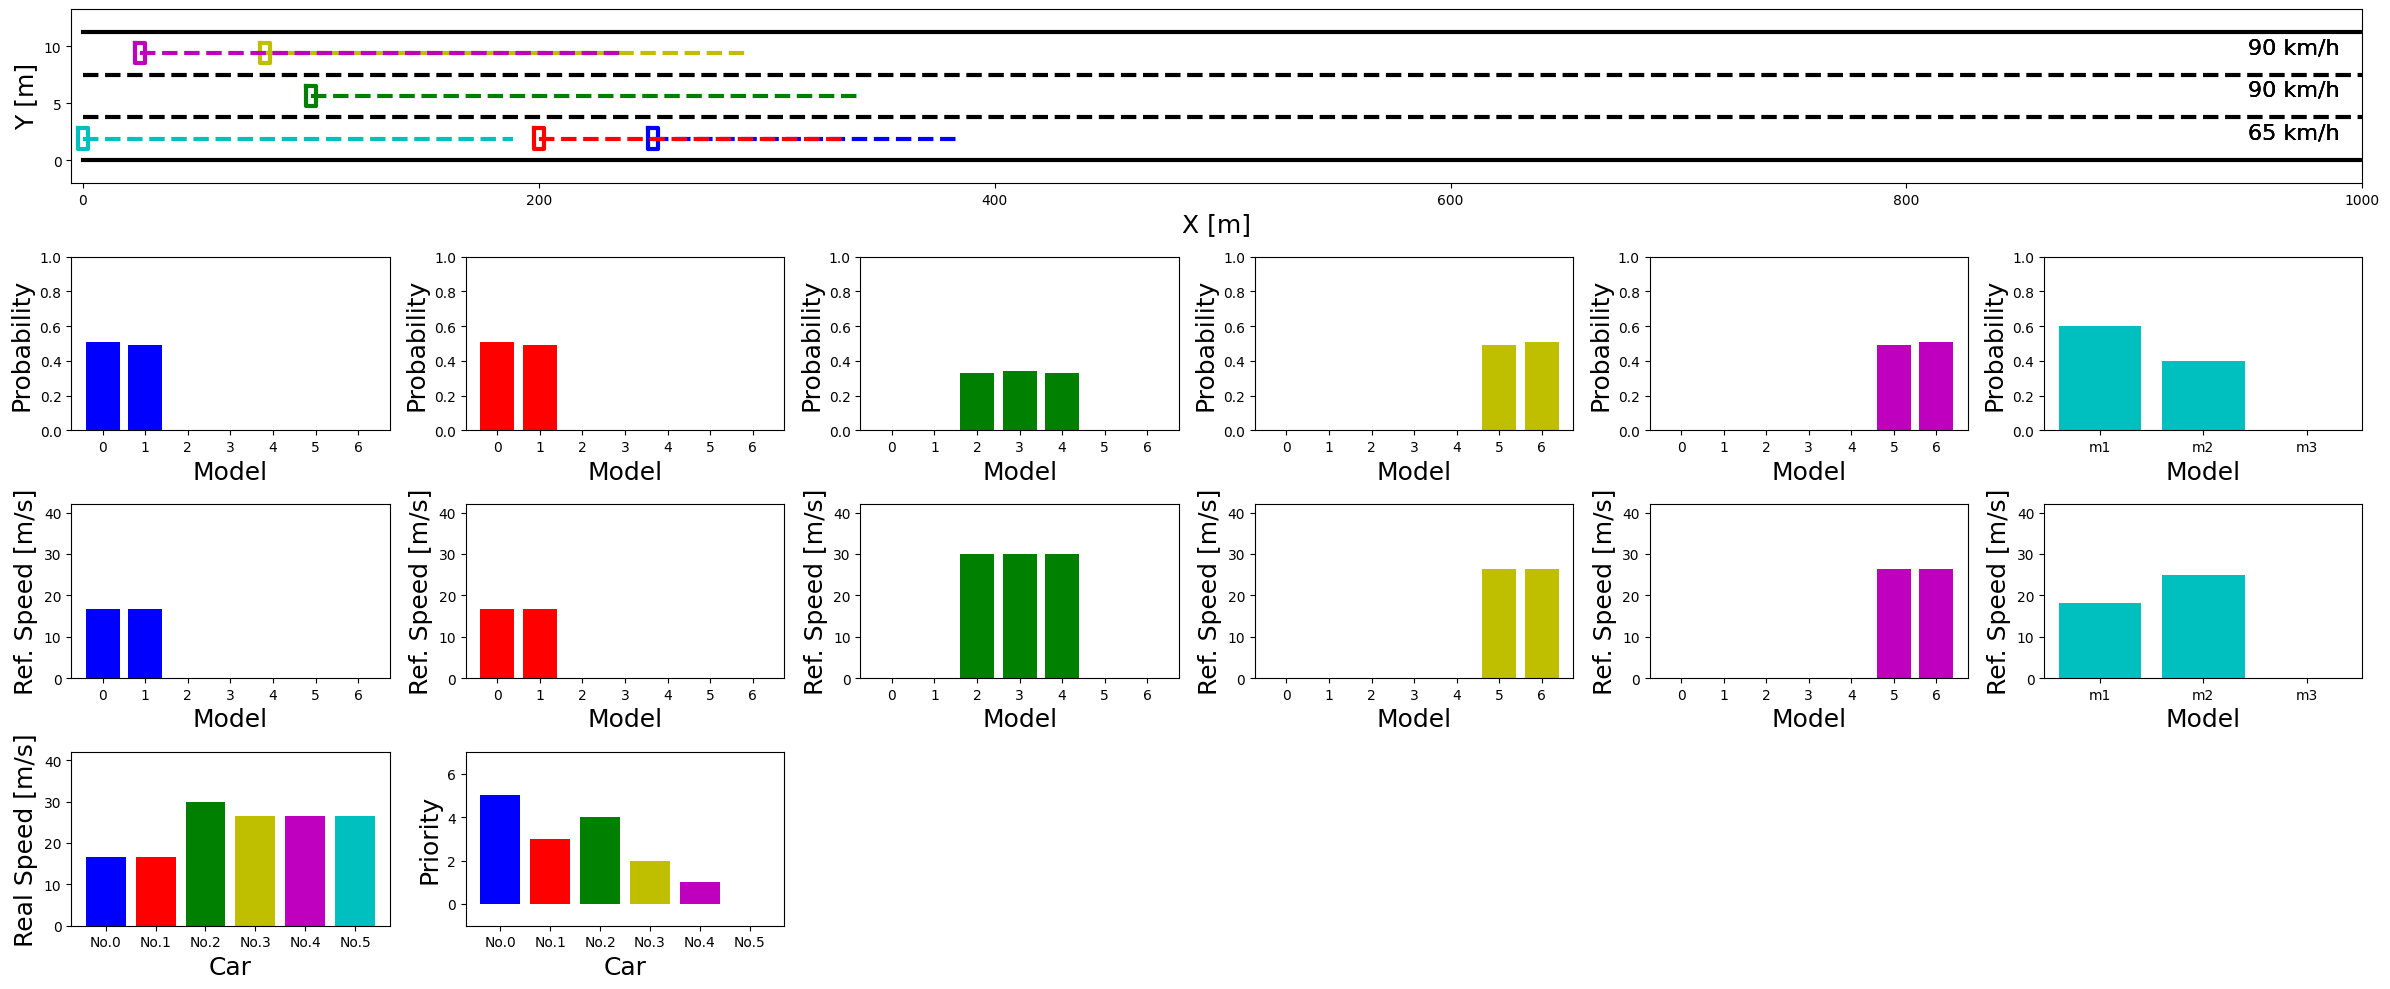

In [9]:
%matplotlib inline
control_index = 1
color_car = ['b', 'r', 'g', 'y', 'm', 'c'] 
color_tra = ['b--', 'r--', 'g--', 'y--', 'm--', 'c--']
x_max = 1000 
fig = plt.figure(figsize=(24, 10), tight_layout = True)
ax = fig.add_subplot(4,1,1,xlim=(-5,  x_max), ylim=(-2, L_Bound[-1] - L_Bound[0]+2))
ax_pro_0 = fig.add_subplot(4, 6, 7,   ylim=(0, 1))
ax_pro_1 = fig.add_subplot(4, 6, 8,   ylim=(0, 1))
ax_pro_2 = fig.add_subplot(4, 6, 9,   ylim=(0, 1))
ax_pro_3 = fig.add_subplot(4, 6, 10, ylim=(0, 1))
ax_pro_4 = fig.add_subplot(4, 6, 11, ylim=(0, 1))
ax_pro_5 = fig.add_subplot(4, 6, 12, ylim=(0, 1))
ax_ref_0 =  fig.add_subplot(4, 6, 13, ylim = (0, 42))
ax_ref_1 =  fig.add_subplot(4, 6, 14, ylim = (0, 42))
ax_ref_2 =  fig.add_subplot(4, 6, 15, ylim = (0, 42))
ax_ref_3 =  fig.add_subplot(4, 6, 16, ylim = (0, 42))
ax_ref_4 =  fig.add_subplot(4, 6, 17, ylim = (0, 42))
ax_ref_5 =  fig.add_subplot(4, 6, 18, ylim = (0, 42))
ax_real_speed = fig.add_subplot(4, 6, 19, ylim = (0, 42))
ax_prio_list = fig.add_subplot(4, 6, 20, ylim = (-1, 7))
ax.set_xlabel('X [m]', fontsize = 18)
ax.set_ylabel('Y [m]', fontsize = 18)
ax_pro_0.set_xlabel('Model', fontsize = 18)
ax_pro_0.set_ylabel('Probability', fontsize = 18)
ax_pro_1.set_xlabel('Model', fontsize = 18)
ax_pro_1.set_ylabel('Probability', fontsize = 18)
ax_pro_2.set_xlabel('Model', fontsize = 18)
ax_pro_2.set_ylabel('Probability', fontsize = 18)
ax_pro_3.set_xlabel('Model', fontsize = 18)
ax_pro_3.set_ylabel('Probability', fontsize = 18)
ax_pro_4.set_xlabel('Model', fontsize = 18)
ax_pro_4.set_ylabel('Probability', fontsize = 18)
ax_pro_5.set_xlabel('Model', fontsize = 18)
ax_pro_5.set_ylabel('Probability', fontsize = 18)
ax_ref_0.set_xlabel('Model', fontsize = 18)
ax_ref_0.set_ylabel('Ref. Speed [m/s]', fontsize = 18)
ax_ref_1.set_xlabel('Model', fontsize = 18)
ax_ref_1.set_ylabel('Ref. Speed [m/s]', fontsize = 18)
ax_ref_2.set_xlabel('Model', fontsize = 18)
ax_ref_2.set_ylabel('Ref. Speed [m/s]', fontsize = 18)
ax_ref_3.set_xlabel('Model', fontsize = 18)
ax_ref_3.set_ylabel('Ref. Speed [m/s]', fontsize = 18)
ax_ref_4.set_xlabel('Model', fontsize = 18)
ax_ref_4.set_ylabel('Ref. Speed [m/s]', fontsize = 18)
ax_ref_5.set_xlabel('Model', fontsize = 18)
ax_ref_5.set_ylabel('Ref. Speed [m/s]', fontsize = 18)
ax_real_speed.set_xlabel('Car', fontsize = 18)
ax_real_speed.set_ylabel('Real Speed [m/s]', fontsize = 18)
ax_prio_list.set_xlabel('Car', fontsize = 18)
ax_prio_list.set_ylabel('Priority', fontsize = 18)

models_EV = ('m1', 'm2', 'm3')
models_TV = ('0', '1', '2', '3', '4', '5', '6')
car = ('No.0', 'No.1', 'No.2', 'No.3', 'No.4', 'No.5')
prob0 = ax_pro_0.bar(models_TV, MU[0][0], color = color_car[0])
prob1 = ax_pro_1.bar(models_TV, MU[0][1], color = color_car[1])
prob2 = ax_pro_2.bar(models_TV, MU[0][2], color = color_car[2])
prob3 = ax_pro_3.bar(models_TV, MU[0][3], color = color_car[3])
prob4 = ax_pro_4.bar(models_TV, MU[0][4], color = color_car[4])
prob5 = ax_pro_5.bar(models_EV, MU[0][5][control_index ], color = color_car[5])
ref0 = ax_ref_0.bar(models_TV, Ref_Speed_All[0][0], color = color_car[0])
ref1 = ax_ref_1.bar(models_TV, Ref_Speed_All[0][1], color = color_car[1])
ref2 = ax_ref_2.bar(models_TV, Ref_Speed_All[0][2], color = color_car[2])
ref3 = ax_ref_3.bar(models_TV, Ref_Speed_All[0][3], color = color_car[3])
ref4 = ax_ref_4.bar(models_TV, Ref_Speed_All[0][4], color = color_car[4])
ref5 = ax_ref_5.bar(models_EV, Ref_Speed_All[0][5][control_index ], color = color_car[5])
Real_Speed_0 = [Y[0][0][1], Y[0][1][1], Y[0][2][1], Y[0][3][1], Y[0][4][1], Y[0][5][control_index][1]]
real_speed = ax_real_speed.bar(car, Real_Speed_0, color = color_car)
priority = ax_prio_list.bar(car, Prio_List[0], color = color_car)
                      
state = tuple([ax.plot(np.nan, np.nan, color_car[k], linewidth=3)[0] for k in range(N_Car)])
trajec = tuple([ax.plot(np.nan, np.nan, color_tra[k], linewidth=3)[0] for k in range(N_Car)])


OCC_SV_0 = tuple([ax.plot(np.nan, np.nan, 'b', linewidth=1)[0] for k in range(N+1)])
OCC_SV_1 = tuple([ax.plot(np.nan, np.nan, 'r', linewidth=1)[0] for k in range(N+1)])
OCC_SV_2 = tuple([ax.plot(np.nan, np.nan, 'g', linewidth=1)[0] for k in range(N+1)])
OCC_SV_3 = tuple([ax.plot(np.nan, np.nan, 'y', linewidth=1)[0] for k in range(N+1)])
OCC_SV_4 = tuple([ax.plot(np.nan, np.nan, 'm', linewidth=1)[0] for k in range(N+1)])

def animate(i):
    
    for idx, statei in enumerate(state):
        if idx != index_EV:
            x_pos = X_State[i][idx][0]
            y_pos = X_State[i][idx][3]
            heading = np.arctan(X_State[i][idx][4]/X_State[i][idx][1])
            x_state, y_state = Cal_Vertex(x_pos, y_pos, heading, l_veh, w_veh)    
        else:
            x_pos = X_State[i][idx][control_index][0]
            y_pos = X_State[i][idx][control_index][3]
            heading = np.arctan(X_State[i][idx][control_index][4]/X_State[i][idx][control_index][1])
            x_state, y_state = Cal_Vertex(x_pos, y_pos, heading, l_veh, w_veh)    
        statei.set_xdata(x_state)
        statei.set_ydata(y_state)
        
    for idx, trajeci in enumerate(trajec):
        if idx != index_EV:
            x_trajec = X_Pre[i][idx][0]
            y_trajec = X_Pre[i][idx][3]
        else:
            x_trajec = X_Pre[i][idx][control_index ][0]
            y_trajec = X_Pre[i][idx][control_index ][3]
        trajeci.set_xdata(x_trajec)
        trajeci.set_ydata(y_trajec)
    
    for idx, OCC_SV_i in enumerate(OCC_SV_0):
        if np.sum( OCC_SV[i][control_index ][0]) == None:
            OCC_SV_i.set_xdata([np.nan, np.nan, np.nan, np.nan, np.nan])
            OCC_SV_i.set_ydata([np.nan, np.nan, np.nan, np.nan, np.nan])
        else:
            x_OCC, y_OCC = OCC_SV_Vertex(OCC_SV[i][control_index ][0][:, idx])
            OCC_SV_i.set_xdata(x_OCC)
            OCC_SV_i.set_ydata(y_OCC)
    
    for idx, OCC_SV_i in enumerate(OCC_SV_1):
        if np.sum(OCC_SV[i][control_index ][1]) == None:
            OCC_SV_i.set_xdata([np.nan, np.nan, np.nan, np.nan, np.nan])
            OCC_SV_i.set_ydata([np.nan, np.nan, np.nan, np.nan, np.nan])
        else:
            x_OCC_SV, y_OCC_SV = OCC_SV_Vertex(OCC_SV[i][control_index ][1][:, idx])
            OCC_SV_i.set_xdata(x_OCC_SV)
            OCC_SV_i.set_ydata(y_OCC_SV)
        
    for idx, OCC_SV_i in enumerate(OCC_SV_2):
        if np.sum(OCC_SV[i][control_index ][2]) == None:
            OCC_SV_i.set_xdata([np.nan, np.nan, np.nan, np.nan, np.nan])
            OCC_SV_i.set_ydata([np.nan, np.nan, np.nan, np.nan, np.nan])
        else:
            x_OCC_SV, y_OCC_SV = OCC_SV_Vertex( OCC_SV[i][control_index ][2][:, idx])
            OCC_SV_i.set_xdata(x_OCC_SV)
            OCC_SV_i.set_ydata(y_OCC_SV)
    
    for idx, OCC_SV_i in enumerate(OCC_SV_3):
        if np.sum(OCC_SV[i][0][3]) == None:
            OCC_SV_i.set_xdata([np.nan, np.nan, np.nan, np.nan, np.nan])
            OCC_SV_i.set_ydata([np.nan, np.nan, np.nan, np.nan, np.nan])
        else:
            x_OCC_SV, y_OCC_SV = OCC_SV_Vertex(OCC_SV[i][0][3][:, idx])
            OCC_SV_i.set_xdata(x_OCC_SV)
            OCC_SV_i.set_ydata(y_OCC_SV)
    
    for idx, OCC_SV_i in enumerate(OCC_SV_4):
        if np.sum(OCC_SV[i][control_index ][4]) == None:
            OCC_SV_i.set_xdata([np.nan, np.nan, np.nan, np.nan, np.nan])
            OCC_SV_i.set_ydata([np.nan, np.nan, np.nan, np.nan, np.nan])
        else:
            x_OCC_SV, y_OCC_SV = OCC_SV_Vertex(OCC_SV[i][control_index ][4][:, idx])
            OCC_SV_i.set_xdata(x_OCC_SV)
            OCC_SV_i.set_ydata(y_OCC_SV)
        
    for rect0 ,y0i in zip(prob0, MU[i][0]):
        rect0.set_height(y0i)
    for rect1 ,y1i in zip(prob1, MU[i][1]):
        rect1.set_height(y1i)
    for rect2 ,y2i in zip(prob2, MU[i][2]):
        rect2.set_height(y2i)
    for rect3 ,y3i in zip(prob3, MU[i][3]):
        rect3.set_height(y3i)
    for rect4 ,y4i in zip(prob4, MU[i][4]):
        rect4.set_height(y4i)
    for rect5 ,y5i in zip(prob5, MU[i][5][control_index ]):
        rect5.set_height(y5i)
    
    for rect0, y0i in zip(ref0, Ref_Speed_All[i][0]):
        rect0.set_height(y0i)
    for rect1, y1i in zip(ref1, Ref_Speed_All[i][1]):
         rect1.set_height(y1i)
    for rect2, y2i in zip(ref2, Ref_Speed_All[i][2]):
         rect2.set_height(y2i)
    for rect3, y3i in zip(ref3, Ref_Speed_All[i][3]):
         rect3.set_height(y3i)
    for rect4, y4i in zip(ref4, Ref_Speed_All[i][4]):
         rect4.set_height(y4i)
    for rect5, y5i in zip(ref5, Ref_Speed_All[i][5][control_index ]):
         rect5.set_height(y5i)

    Real_Speed_i = [Y[i][0][1], Y[i][1][1], Y[i][2][1], Y[i][3][1], Y[i][4][1], Y[i][5][control_index][1]]
    for rect, y in zip(real_speed, Real_Speed_i):
        rect.set_height(y)
    
    for rect, y in zip(priority, Prio_List[i]):
        rect.set_height(y)
    
    return state, trajec, OCC_SV_0, OCC_SV_1, OCC_SV_2, OCC_SV_3, OCC_SV_4,  prob0, prob1, prob2, prob3, prob4, prob5, ref0, ref1, ref2, ref3, ref4, ref5, real_speed, priority

SpeedLim_Ani = SpeedLim*3.6

for i in range(N_Lane):
    ax.text(x_max-50, L_No1, '%.0f km/h'%SpeedLim_Ani[0], fontsize = 16)
    ax.text(x_max-50, L_No2, '%.0f km/h'%SpeedLim_Ani[1], fontsize = 16)
    ax.text(x_max-50, L_No3, '%.0f km/h'%SpeedLim_Ani[2], fontsize = 16)
ax.plot(np.linspace(0, x_max, num = x_max), np.array([L_Bound[0]]*x_max), 'k', linewidth = 3)
ax.plot(np.linspace(0, x_max, num = x_max), np.array([L_Bound[1]]*x_max), 'k--', linewidth = 3)
ax.plot(np.linspace(0, x_max, num = x_max), np.array([L_Bound[2]]*x_max), 'k--', linewidth = 3)
ax.plot(np.linspace(0, x_max, num = x_max), np.array([L_Bound[3]]*x_max), 'k', linewidth = 3)
            
ani = animation.FuncAnimation(fig, animate, frames = K_N, blit = False)
ani.save('Movie_2.mp4',writer='ffmpeg', fps=1000/50) # Save to whereever you want

##### 8.3 Results for epsilon = 1

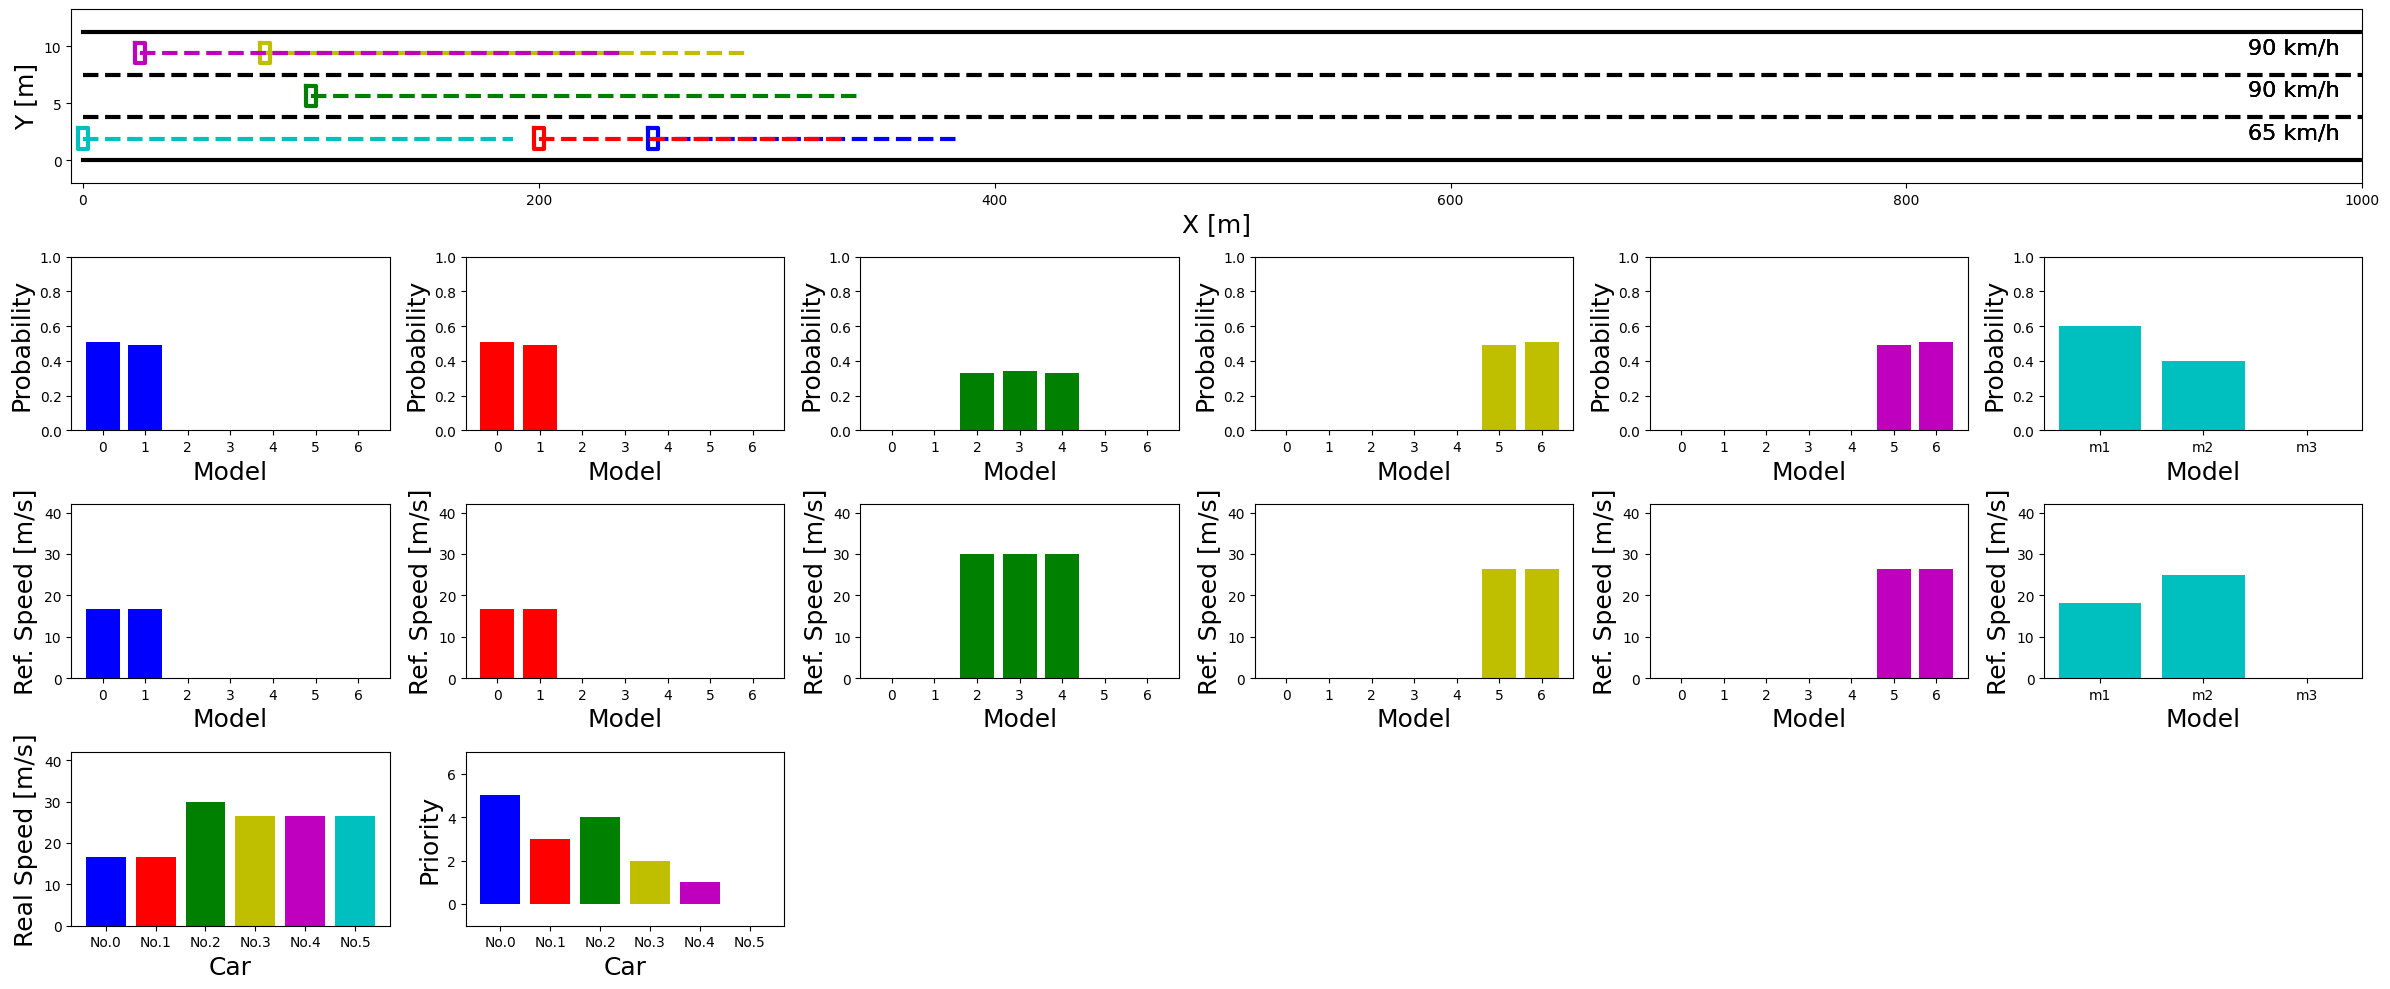

In [10]:
%matplotlib inline
control_index = 2
color_car = ['b', 'r', 'g', 'y', 'm', 'c'] 
color_tra = ['b--', 'r--', 'g--', 'y--', 'm--', 'c--']
x_max = 1000
fig = plt.figure(figsize=(24, 10), tight_layout = True)
ax = fig.add_subplot(4,1,1,xlim=(-5,  x_max), ylim=(-2, L_Bound[-1] - L_Bound[0]+2))
ax_pro_0 = fig.add_subplot(4, 6, 7,   ylim=(0, 1))
ax_pro_1 = fig.add_subplot(4, 6, 8,   ylim=(0, 1))
ax_pro_2 = fig.add_subplot(4, 6, 9,   ylim=(0, 1))
ax_pro_3 = fig.add_subplot(4, 6, 10, ylim=(0, 1))
ax_pro_4 = fig.add_subplot(4, 6, 11, ylim=(0, 1))
ax_pro_5 = fig.add_subplot(4, 6, 12, ylim=(0, 1))
ax_ref_0 =  fig.add_subplot(4, 6, 13, ylim = (0, 42))
ax_ref_1 =  fig.add_subplot(4, 6, 14, ylim = (0, 42))
ax_ref_2 =  fig.add_subplot(4, 6, 15, ylim = (0, 42))
ax_ref_3 =  fig.add_subplot(4, 6, 16, ylim = (0, 42))
ax_ref_4 =  fig.add_subplot(4, 6, 17, ylim = (0, 42))
ax_ref_5 =  fig.add_subplot(4, 6, 18, ylim = (0, 42))
ax_real_speed = fig.add_subplot(4, 6, 19, ylim = (0, 42))
ax_prio_list = fig.add_subplot(4, 6, 20, ylim = (-1, 7))
ax.set_xlabel('X [m]', fontsize = 18)
ax.set_ylabel('Y [m]', fontsize = 18)
ax_pro_0.set_xlabel('Model', fontsize = 18)
ax_pro_0.set_ylabel('Probability', fontsize = 18)
ax_pro_1.set_xlabel('Model', fontsize = 18)
ax_pro_1.set_ylabel('Probability', fontsize = 18)
ax_pro_2.set_xlabel('Model', fontsize = 18)
ax_pro_2.set_ylabel('Probability', fontsize = 18)
ax_pro_3.set_xlabel('Model', fontsize = 18)
ax_pro_3.set_ylabel('Probability', fontsize = 18)
ax_pro_4.set_xlabel('Model', fontsize = 18)
ax_pro_4.set_ylabel('Probability', fontsize = 18)
ax_pro_5.set_xlabel('Model', fontsize = 18)
ax_pro_5.set_ylabel('Probability', fontsize = 18)
ax_ref_0.set_xlabel('Model', fontsize = 18)
ax_ref_0.set_ylabel('Ref. Speed [m/s]', fontsize = 18)
ax_ref_1.set_xlabel('Model', fontsize = 18)
ax_ref_1.set_ylabel('Ref. Speed [m/s]', fontsize = 18)
ax_ref_2.set_xlabel('Model', fontsize = 18)
ax_ref_2.set_ylabel('Ref. Speed [m/s]', fontsize = 18)
ax_ref_3.set_xlabel('Model', fontsize = 18)
ax_ref_3.set_ylabel('Ref. Speed [m/s]', fontsize = 18)
ax_ref_4.set_xlabel('Model', fontsize = 18)
ax_ref_4.set_ylabel('Ref. Speed [m/s]', fontsize = 18)
ax_ref_5.set_xlabel('Model', fontsize = 18)
ax_ref_5.set_ylabel('Ref. Speed [m/s]', fontsize = 18)
ax_real_speed.set_xlabel('Car', fontsize = 18)
ax_real_speed.set_ylabel('Real Speed [m/s]', fontsize = 18)
ax_prio_list.set_xlabel('Car', fontsize = 18)
ax_prio_list.set_ylabel('Priority', fontsize = 18)

models_EV = ('m1', 'm2', 'm3')
models_TV = ('0', '1', '2', '3', '4', '5', '6')
car = ('No.0', 'No.1', 'No.2', 'No.3', 'No.4', 'No.5')
prob0 = ax_pro_0.bar(models_TV, MU[0][0], color = color_car[0])
prob1 = ax_pro_1.bar(models_TV, MU[0][1], color = color_car[1])
prob2 = ax_pro_2.bar(models_TV, MU[0][2], color = color_car[2])
prob3 = ax_pro_3.bar(models_TV, MU[0][3], color = color_car[3])
prob4 = ax_pro_4.bar(models_TV, MU[0][4], color = color_car[4])
prob5 = ax_pro_5.bar(models_EV, MU[0][5][control_index ], color = color_car[5])
ref0 = ax_ref_0.bar(models_TV, Ref_Speed_All[0][0], color = color_car[0])
ref1 = ax_ref_1.bar(models_TV, Ref_Speed_All[0][1], color = color_car[1])
ref2 = ax_ref_2.bar(models_TV, Ref_Speed_All[0][2], color = color_car[2])
ref3 = ax_ref_3.bar(models_TV, Ref_Speed_All[0][3], color = color_car[3])
ref4 = ax_ref_4.bar(models_TV, Ref_Speed_All[0][4], color = color_car[4])
ref5 = ax_ref_5.bar(models_EV, Ref_Speed_All[0][5][control_index ], color = color_car[5])
Real_Speed_0 = [Y[0][0][1], Y[0][1][1], Y[0][2][1], Y[0][3][1], Y[0][4][1], Y[0][5][control_index][1]]
real_speed = ax_real_speed.bar(car, Real_Speed_0, color = color_car)
priority = ax_prio_list.bar(car, Prio_List[0], color = color_car)
                      
state = tuple([ax.plot(np.nan, np.nan, color_car[k], linewidth=3)[0] for k in range(N_Car)])
trajec = tuple([ax.plot(np.nan, np.nan, color_tra[k], linewidth=3)[0] for k in range(N_Car)])

OCC_SV_0 = tuple([ax.plot(np.nan, np.nan, 'b', linewidth=1)[0] for k in range(N+1)])
OCC_SV_1 = tuple([ax.plot(np.nan, np.nan, 'r', linewidth=1)[0] for k in range(N+1)])
OCC_SV_2 = tuple([ax.plot(np.nan, np.nan, 'g', linewidth=1)[0] for k in range(N+1)])
OCC_SV_3 = tuple([ax.plot(np.nan, np.nan, 'y', linewidth=1)[0] for k in range(N+1)])
OCC_SV_4 = tuple([ax.plot(np.nan, np.nan, 'm', linewidth=1)[0] for k in range(N+1)])

def animate(i):
    
    for idx, statei in enumerate(state):
        if idx != index_EV:
            x_pos = X_State[i][idx][0]
            y_pos = X_State[i][idx][3]
            heading = np.arctan(X_State[i][idx][4]/X_State[i][idx][1])
            x_state, y_state = Cal_Vertex(x_pos, y_pos, heading, l_veh, w_veh)    
        else:
            x_pos = X_State[i][idx][control_index][0]
            y_pos = X_State[i][idx][control_index][3]
            heading = np.arctan(X_State[i][idx][control_index][4]/X_State[i][idx][control_index][1])
            x_state, y_state = Cal_Vertex(x_pos, y_pos, heading, l_veh, w_veh)    
        statei.set_xdata(x_state)
        statei.set_ydata(y_state)
        
    for idx, trajeci in enumerate(trajec):
        if idx != index_EV:
            x_trajec = X_Pre[i][idx][0]
            y_trajec = X_Pre[i][idx][3]
        else:
            x_trajec = X_Pre[i][idx][control_index ][0]
            y_trajec = X_Pre[i][idx][control_index ][3]
        trajeci.set_xdata(x_trajec)
        trajeci.set_ydata(y_trajec)
    
    for idx, OCC_SV_i in enumerate(OCC_SV_0):
        if np.sum( OCC_SV[i][control_index ][0]) == None:
            OCC_SV_i.set_xdata([np.nan, np.nan, np.nan, np.nan, np.nan])
            OCC_SV_i.set_ydata([np.nan, np.nan, np.nan, np.nan, np.nan])
        else:
            x_OCC, y_OCC = OCC_SV_Vertex(OCC_SV[i][control_index ][0][:, idx])
            OCC_SV_i.set_xdata(x_OCC)
            OCC_SV_i.set_ydata(y_OCC)
    
    for idx, OCC_SV_i in enumerate(OCC_SV_1):
        if np.sum(OCC_SV[i][control_index ][1]) == None:
            OCC_SV_i.set_xdata([np.nan, np.nan, np.nan, np.nan, np.nan])
            OCC_SV_i.set_ydata([np.nan, np.nan, np.nan, np.nan, np.nan])
        else:
            x_OCC_SV, y_OCC_SV = OCC_SV_Vertex(OCC_SV[i][control_index ][1][:, idx])
            OCC_SV_i.set_xdata(x_OCC_SV)
            OCC_SV_i.set_ydata(y_OCC_SV)
        
    for idx, OCC_SV_i in enumerate(OCC_SV_2):
        if np.sum(OCC_SV[i][control_index ][2]) == None:
            OCC_SV_i.set_xdata([np.nan, np.nan, np.nan, np.nan, np.nan])
            OCC_SV_i.set_ydata([np.nan, np.nan, np.nan, np.nan, np.nan])
        else:
            x_OCC_SV, y_OCC_SV = OCC_SV_Vertex( OCC_SV[i][control_index ][2][:, idx])
            OCC_SV_i.set_xdata(x_OCC_SV)
            OCC_SV_i.set_ydata(y_OCC_SV)
    
    for idx, OCC_SV_i in enumerate(OCC_SV_3):
        if np.sum(OCC_SV[i][0][3]) == None:
            OCC_SV_i.set_xdata([np.nan, np.nan, np.nan, np.nan, np.nan])
            OCC_SV_i.set_ydata([np.nan, np.nan, np.nan, np.nan, np.nan])
        else:
            x_OCC_SV, y_OCC_SV = OCC_SV_Vertex(OCC_SV[i][0][3][:, idx])
            OCC_SV_i.set_xdata(x_OCC_SV)
            OCC_SV_i.set_ydata(y_OCC_SV)
    
    for idx, OCC_SV_i in enumerate(OCC_SV_4):
        if np.sum(OCC_SV[i][control_index ][4]) == None:
            OCC_SV_i.set_xdata([np.nan, np.nan, np.nan, np.nan, np.nan])
            OCC_SV_i.set_ydata([np.nan, np.nan, np.nan, np.nan, np.nan])
        else:
            x_OCC_SV, y_OCC_SV = OCC_SV_Vertex(OCC_SV[i][control_index ][4][:, idx])
            OCC_SV_i.set_xdata(x_OCC_SV)
            OCC_SV_i.set_ydata(y_OCC_SV)
        
    for rect0 ,y0i in zip(prob0, MU[i][0]):
        rect0.set_height(y0i)
    for rect1 ,y1i in zip(prob1, MU[i][1]):
        rect1.set_height(y1i)
    for rect2 ,y2i in zip(prob2, MU[i][2]):
        rect2.set_height(y2i)
    for rect3 ,y3i in zip(prob3, MU[i][3]):
        rect3.set_height(y3i)
    for rect4 ,y4i in zip(prob4, MU[i][4]):
        rect4.set_height(y4i)
    for rect5 ,y5i in zip(prob5, MU[i][5][control_index ]):
        rect5.set_height(y5i)
    
    for rect0, y0i in zip(ref0, Ref_Speed_All[i][0]):
        rect0.set_height(y0i)
    for rect1, y1i in zip(ref1, Ref_Speed_All[i][1]):
         rect1.set_height(y1i)
    for rect2, y2i in zip(ref2, Ref_Speed_All[i][2]):
         rect2.set_height(y2i)
    for rect3, y3i in zip(ref3, Ref_Speed_All[i][3]):
         rect3.set_height(y3i)
    for rect4, y4i in zip(ref4, Ref_Speed_All[i][4]):
         rect4.set_height(y4i)
    for rect5, y5i in zip(ref5, Ref_Speed_All[i][5][control_index ]):
         rect5.set_height(y5i)

    Real_Speed_i = [Y[i][0][1], Y[i][1][1], Y[i][2][1], Y[i][3][1], Y[i][4][1], Y[i][5][control_index][1]]
    for rect, y in zip(real_speed, Real_Speed_i):
        rect.set_height(y)
    
    for rect, y in zip(priority, Prio_List[i]):
        rect.set_height(y)
    
    return state, trajec, OCC_SV_0, OCC_SV_1, OCC_SV_2, OCC_SV_3, OCC_SV_4,  prob0, prob1, prob2, prob3, prob4, prob5, ref0, ref1, ref2, ref3, ref4, ref5, real_speed, priority

SpeedLim_Ani = SpeedLim*3.6

for i in range(N_Lane):
    ax.text(x_max-50, L_No1, '%.0f km/h'%SpeedLim_Ani[0], fontsize = 16)
    ax.text(x_max-50, L_No2, '%.0f km/h'%SpeedLim_Ani[1], fontsize = 16)
    ax.text(x_max-50, L_No3, '%.0f km/h'%SpeedLim_Ani[2], fontsize = 16)
ax.plot(np.linspace(0, x_max, num = x_max), np.array([L_Bound[0]]*x_max), 'k', linewidth = 3)
ax.plot(np.linspace(0, x_max, num = x_max), np.array([L_Bound[1]]*x_max), 'k--', linewidth = 3)
ax.plot(np.linspace(0, x_max, num = x_max), np.array([L_Bound[2]]*x_max), 'k--', linewidth = 3)
ax.plot(np.linspace(0, x_max, num = x_max), np.array([L_Bound[3]]*x_max), 'k', linewidth = 3)
ani = animation.FuncAnimation(fig, animate, frames = K_N, blit = False)
ani.save('Movie_3.mp4',writer='ffmpeg', fps=1000/50) # Save to whereever you want

###  9. Save the Data to Whereever You Want

In [11]:
np.save('t.npy', t)
np.save('State_EV_LOC_Small_Eps.npy', State_EV_LOC_Small_Eps) # State of EV in the local coordinate system with eps. = 0.1
np.save('State_EV_LOC_Large_Eps.npy', State_EV_LOC_Large_Eps) # State of EV in the local coordinate system with eps. = 0.4
np.save('State_EV_LOC_Determini.npy', State_EV_LOC_Determini) # State of EV in the local coordinate system with eps. = 1.0

np.save('Ref_Speed_EV_Small_Eps.npy', Ref_Speed_EV_Small_Eps) # Reference speed of EV with eps. = 0.1
np.save('Ref_Speed_EV_Large_Eps.npy', Ref_Speed_EV_Large_Eps) # Reference speed of EV with eps. = 0.1
np.save('Ref_Speed_EV_Determini.npy', Ref_Speed_EV_Determini) # Reference speed of EV with eps. = 1.0

np.save('Ref_Lane_EV_Small_Eps.npy', Ref_Lane_EV_Small_Eps)   # Reference lane of EV with eps. = 0.1
np.save('Ref_Lane_EV_Large_Eps.npy', Ref_Lane_EV_Large_Eps)   # Reference lane of EV with eps. = 0.4
np.save('Ref_Lane_EV_Determini.npy', Ref_Lane_EV_Determini)   # Reference lane of EV with eps. = 1.0

np.save('State_SV4.npy', State_SV_4)                          # State of SV4